In [1]:
# Only needed for the first run
#exec(open("torchsampler/__init__.py").read())
#exec(open("torchsampler/imbalanced.py").read())

In [2]:
# Main block of code
exec(open("net.py").read())
exec(open("load_data.py").read())
exec(open("test.py").read())

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)
[1,  2000] loss: 0.692
[2,  2000] loss: 0.525
[3,  2000] loss: 0.139
[4,  2000] loss: 0.083
[5,  2000] loss: 0.054
[6,  2000] loss: 0.039
[7,  2000] loss: 0.031
[8,  2000] loss: 0.026
Finished Training
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
1

In [6]:
# Taken from https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/
# Adapted to work with tensors (I think thats what I did?)

# Addapted
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # we extract coordinates for every 
    # prediction box present in P
    x1t = []
    y1t = []
    x2t = []
    y2t = []
    scorest = []

    for i in range(len(P)):
        x1t.append(P[i][0])
        y1t.append(P[i][1])
        x2t.append(P[i][2])
        y2t.append(P[i][3])
        scorest.append(P[i][4])

    # Using append above instead of this from the original code because this doesn't work with tensors or whatever
    # x1 = P[:, 0]
    # y1 = P[:, 1]
    # x2 = P[:, 2]
    # y2 = P[:, 3]

    # Convert back to tensor
    x1 = torch.FloatTensor(x1t)
    y1 = torch.FloatTensor(y1t)
    x2 = torch.FloatTensor(x2t)
    y2 = torch.FloatTensor(y2t)
    scores = torch.FloatTensor(scorest)
    

    # we extract the confidence scores as well
    #scores = P[:, 4]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
    
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
    

    while len(order) > 0:
        
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(P[idx])

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break
        
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
        
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep

In [14]:
# His code
import cv2
import numpy as np
def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[0] / scale)
        h = int(image.shape[1] / scale)
        #image = imutils.resize(image, width=w)
        image = cv2.resize(image, (h,w))
        
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


def pyramid_sliding_window_detection(net, image, scale, winW, winH, stepSize):
    # Store the initial image before resize, it will be used for the final printing
    faces_img = image.copy()
   
    # loop over the image pyramid
    # all_detected_faces : contains for each pyramid level the scaling factor and the detected faces corresponding to
    # pyramid level
    all_detected_faces = []
    for resized in pyramid(image, scale=scale):
        detected_faces = []
        curr_scale_factor = image.shape[0] / resized.shape[0]
        # loop over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(resized, stepSize=stepSize, windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            # We use the 36*36 window to match the net's img input size
            resized_tensor = torch.from_numpy(window)
            # Transform the 500*500 (2d) img to a 4d tensor (the additional 2 dimensions contain no information)
            resized_tensor = resized_tensor[None, None, :, :]  # tensor shape is now [1,1,500,500]
            # Feed the network the input tensor
            output = net(resized_tensor)

            # We only register faces with a prob higher than 0.99 to avoid false positives
            # (softmax dim parameter : dim=0->rows add up to 1, dim=1->rows add up to 1)
            softmax = torch.nn.functional.softmax(output, dim=1)
            if softmax[0][1] >= 0.99:
                detected_faces.append((x, y,softmax[0][1]))


        #Add the detected faces and the corresponding factors to the all_faces variable
        all_detected_faces.append([curr_scale_factor,detected_faces])
  

    # We use the non_max_supp algorithm to delete overlaping bounding boxes
    # to avoid detecting the same face multiple times
    for j in range(len(all_detected_faces)):
        for i in range(len(all_detected_faces[j][1])): #all_detected_faces[j][1]->detected faces of the i-pyramid-level
            # in this line we both :
            # - change the tuple from a 2d (startX, startY) to a 4d (startX, startY, endX, endY)
            # - multiply each number of the tuple by the current scale factor
            all_detected_faces[j][1][i] = (
                                              all_detected_faces[j][1][i][0] * all_detected_faces[j][0], all_detected_faces[j][1][i][1] * all_detected_faces[j][0]
                                          ) + (
                                            (all_detected_faces[j][1][i][0] + winW)*all_detected_faces[j][0], (all_detected_faces[j][1][i][1] + winH)*all_detected_faces[j][0]
                                            ,all_detected_faces[j][1][i][2]
            )

    # Concatenate detected faces into the same array
    final_detected_faces = all_detected_faces
    return final_detected_faces

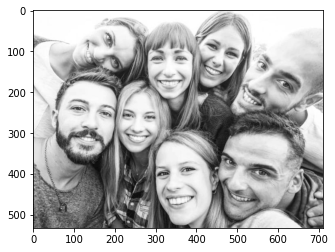

In [15]:
from PIL import Image

filename="faces7.jpeg" #Change file-name here to change image used

import torch
import matplotlib.pyplot as plt

testimg = cv2.imread(filename)
gray = cv2.cvtColor(testimg, cv2.COLOR_BGR2GRAY).astype(float)
gray = gray/128.0 - 1.0
plt.imshow(gray, cmap="gray")
plt.show()

bboxes = pyramid_sliding_window_detection(net,np.asarray(gray, dtype='float32'), 1.2, 36, 36, 5)

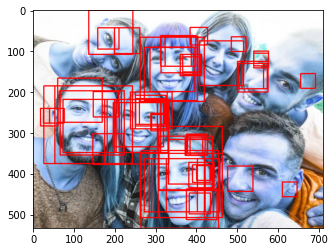

In [19]:
# HIS CODE FOR IMAGE DRAWING
# Only works without nms

img_result = testimg.copy()
# Here the sliding window is done for one pyramid scale
# We draw the detected faces
for (scale, values) in bboxes:
    for (startX, startY, endX, endY, certainty) in values:
        #Converting the coordinates to int to match cv2.rectangle input type
        startX, startY, endX, endY = int(round(startX)),int(round(startY)), int(round(endX)), int(round(endY))
        img_result = cv2.rectangle(img_result, (startX, startY), (endX, endY), (255, 0, 0), 2)
        #cv2.imshow("Window", faces_img)
#cv2.waitKey(0)
plt.imshow(img_result)
plt.show()

In [32]:
# Adding nms to the detected faces
temp_detected_faces = []
for j in range(len(bboxes)):
    for i in range(len(bboxes[j][1])):
        temp_detected_faces.append(list(bboxes[j][1][i]))

bboxes_nms = nms_pytorch(list(temp_detected_faces), 0.05) # Change the coefficient (0.05 works quite well) 

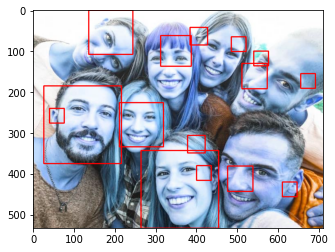

In [33]:
#Modified code to work with NMS

img_result = testimg.copy()
# Here the sliding window is done for one pyramid scale
# We draw the detected faces
for (startX, startY, endX, endY, confidence) in bboxes_nms:
    #Converting the coordinates to int to match cv2.rectangle input type
    startX, startY, endX, endY = int(round(startX)),int(round(startY)), int(round(endX)), int(round(endY))
    img_result = cv2.rectangle(img_result, (startX, startY), (endX, endY), (255, 0, 0), 2)
plt.imshow(img_result)
plt.show()